# Data Mining Report
### by Adam Satria Adidarma & Gayuh Kautaman Rahmad

In this project, we're using the diabetes dataset to do pre-processing, classification, and clustering tasks.

**About the data**
- Pregnancies : number of times pregnant
- Glucose : plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure : Diastolic blood pressure (mm Hg)
- SkinThickness : triceps skin fold thickness (mm)
- Insulin : 2-hour serum insulin (mu U/ml)
- BMI : body mass index
- DiabetesPedigreeFunction : diabetes pedigree function
- Age : age on year
- Outcome : label (0/1)

First, we're doing exploration on the dataset and checking whether the data has any missing values in it or any duplicate values. If there are any, we need to pre-process the data first before putting it in a model because it can lead to certain errors. But fortunately, there seem to be no missing values and duplicates in our data. Next, we check for data imbalances in the model and the result is 65% on 0 and 35% on 1. By checking the correlation between the label and the features, we can see that they all have a positively correlated relationship to each other with glucose as the most correlated to the outcome of diabetes. We use the describe tool to get a summary of the data that we got so far, we noticed there are some 0 values in the features so we need to transform it into a null value transforming it to be a missing value in the data. Therefore, we need to do some pre-processing on this data. We can't just remove these missing values since we have a small amount of data, but we can replace the missing values with the median according to the outcomes which is what we did here.

We tried putting the data into a decision tree and random forest classifier directly after we did this and got an accuracy score of 80-84%. We used this classifier first because it is easy to implement and we can view the tree model from the tutorial code in class. After that, we try to get a higher accuracy score by doing more pre-processing on our data. We check if there's an outlier in our data by using the quantile function from the NumPy library which computes the Q1 and Q3 of the data. The result is that most of the features are all having outliers, and from the data exploration before we can see that the range of our data is very sparse on some attributes. That is why the next step of our pre-processing is to standardize these data and they're transformed into the same range to make it easier to compare. We use a robust scaler transformer to standardize our data from the sklearn library because it's supposed to be robust against outliers since this transformer scales the data from the quantile range which is between the Q1 and Q3. Lastly, we assign X and y as features and label for our model.

Before, we're only using the tree-based classification method but after standardizing the data, we want to see how it performs to other famous classifiers. Hence, we add Logistic Regression, K Nearest Neighbor, and SVM classifiers. We tune these parameters using the grid search tool from the sklearn library. This tool helps search for the best parameter that we specified beforehand on a model. The grid search uses cross-validation for the optimizer. For the splitting strategy of cross-validation, we're using a Kfold of 10 to split the data and evaluate them on each fold. For the final result of the tuning, we can see that the tree-based method has the highest scores compared to the other with random forest having 89% accuracy and decision tree 86%.

For clustering, we create a new data frame without the outcome column because this is the target of our cluster which is 1 and 0. Next, same as before we need to standardize these data first but now we're using the standard scaler function which is using the z-score formula to do the standardization by removing the mean value and scaling it to the unit variance. Since there are so many attributes in this dataset, we use principal component analysis (PCA) to lower the dimensionality of our data to better visualize on a 2D plane for the clustering task. Next, use inertia on k-means which uses the elbow rule to see the optimal number of clusters on our dataset but we stick to just two clusters. Then finally we start the cluster using the k-means method and we got 427 points on cluster 0 and 341 points on cluster 1. To evaluate this result, we use the original dataset that has the real value of 0 and 1 and put it in a confusion matrix, using the formula from the confusion matrix, we got 74% accuracy and 26% error rate.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler


## Data Exploration

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [42]:
print("Null values:")
print(df.isnull().sum())
print("\nduplicate total:" + str(df.duplicated().sum()))
print("checking imbalanceness:")
df['Outcome'].value_counts()

Null values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

duplicate total:0
checking imbalanceness:


0    500
1    268
Name: Outcome, dtype: int64

<AxesSubplot:>

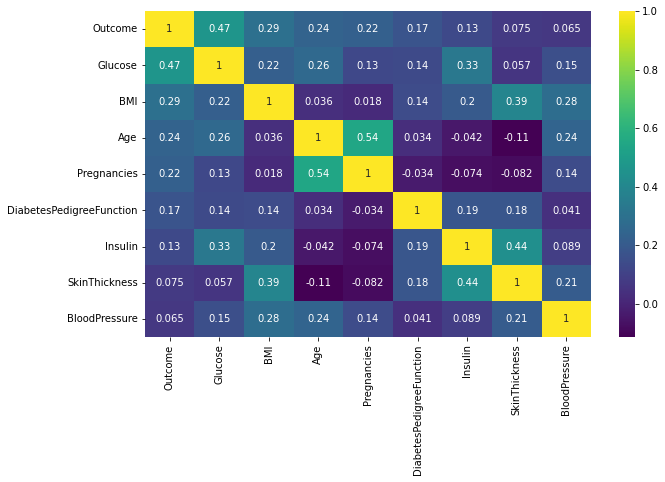

In [43]:
k = 9
cols = df.corr().nlargest(k, 'Outcome')['Outcome'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

## Pre-Processing

In [44]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [45]:
#replace 0 values with nan
cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df[cols] = df[cols].replace({'0':np.nan, 0:np.nan})

In [46]:
for col in df.columns:
    df.loc[(df["Outcome"]==0) & (df[col].isnull()),col] = df[df["Outcome"]==0][col].median()
    df.loc[(df["Outcome"]==1) & (df[col].isnull()),col] = df[df["Outcome"]==1][col].median()

In [47]:
df.head(10)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    169.5  33.6   
1            1     85.0           66.0           29.0    102.5  26.6   
2            8    183.0           64.0           32.0    169.5  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   
5            5    116.0           74.0           27.0    102.5  25.6   
6            3     78.0           50.0           32.0     88.0  31.0   
7           10    115.0           70.0           27.0    102.5  35.3   
8            2    197.0           70.0           45.0    543.0  30.5   
9            8    125.0           96.0           32.0    169.5  34.3   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0  
6                     0.248   26        1  
7                     0.134   29        0  
8                     0.158   53        1  
9                     0.232   54        1

Outlier detection

In [48]:
# Q1 = df["BloodPressure"].quantile(0.25)
# Q3 = df["BloodPressure"].quantile(0.75)
# interQuartileRange = Q3-Q1
# lower = Q1 - 1.5*interQuartileRange
# upper = Q3 + 1.5*interQuartileRange

for list in df:
    Q1 = df[list].quantile(0.25)
    Q3 = df[list].quantile(0.75)
    interQuartileRange = Q3-Q1
    lower = Q1 - 1.5*interQuartileRange
    upper = Q3 + 1.5*interQuartileRange

    if df[(df[list] > upper)].any(axis=None):
        print(list,"yes")
    else:
        print(list, "no")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [49]:
lower

-1.5

In [50]:
upper

2.5

Standardization

In [51]:
X = df.drop(columns= 'Outcome')
y = df['Outcome']

cols = X.columns
index = X.index

In [52]:
transformer = RobustScaler().fit(X)
X = transformer.transform(X) #transform to array changing to df
print(type(X))
X = pd.DataFrame(data = X, columns = cols, index = index)



<class 'numpy.ndarray'>


In [53]:
X

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0            0.6  0.765432          0.000       1.000000  1.000000  0.170330   
1           -0.4 -0.790123         -0.375       0.142857  0.000000 -0.598901   
2            1.0  1.629630         -0.500       0.571429  1.000000 -0.961538   
3           -0.4 -0.691358         -0.375      -0.714286 -0.126866 -0.434066   
4           -0.6  0.493827         -2.000       1.000000  0.977612  1.214286   
..           ...       ...            ...            ...       ...       ...   
763          1.4 -0.395062          0.250       2.857143  1.156716  0.093407   
764         -0.2  0.123457         -0.125      -0.142857  0.000000  0.521978   
765          0.4  0.098765          0.000      -0.714286  0.141791 -0.642857   
766         -0.4  0.222222         -0.750       0.571429  1.000000 -0.214286   
767         -0.4 -0.592593         -0.125       0.428571  0.000000 -0.181319   

     DiabetesPedigreeFunction       Age  
0                    0.665359  1.235294  
1                   -0.056209  0.117647  
2                    0.783007  0.176471  
3                   -0.537255 -0.470588  
4                    5.007843  0.235294  
..                        ...       ...  
763                 -0.526797  2.000000  
764                 -0.084967 -0.117647  
765                 -0.333333  0.058824  
766                 -0.061438  1.058824  
767                 -0.150327 -0.352941  

[768 rows x 8 columns]

## Classification

In [54]:
#trying with default parameters
models = []
models.append(('Logistic Regression', LogisticRegression(random_state = 3)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier(random_state = 3)))
models.append(('Random Forest', RandomForestClassifier(random_state = 3)))
models.append(('SVM', SVC(gamma='auto', random_state = 3)))

In [55]:
#evaluation part
results = []
names = []

for name, model in models:
        #using kfold cross validator        
        validationResult = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(validationResult)
        names.append(name)
        print("%s: %f" % (name, validationResult.mean()))

Logistic Regression: 0.776042
KNN: 0.856801
Decision Tree: 0.841200
Random Forest: 0.888107
SVM: 0.855434


**Tuning the models using grid search**

Random Forest tuning

In [56]:
parameters = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
             "max_depth": [3,5,8,None]}

rf = RandomForestClassifier(random_state = 3)
gs_cv = GridSearchCV(estimator = rf, param_grid = parameters, cv = 10,verbose = 2, return_train_score=True, n_jobs = -1).fit(X, y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators

In [57]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'max_depth': 5, 'max_features': 7, 'min_samples_split': 2, 'n_estimators': 100}
0.8958817498291183


In [59]:
tunedRandomForest = RandomForestClassifier(max_depth=5, max_features=7, min_samples_split=2, n_estimators=100)
tunedRandomForest = tunedRandomForest.fit(X,y)
score = cross_val_score(tunedRandomForest, X, y, cv = 10, scoring= "accuracy").mean()
print(score)

0.8815447710184552


Decision Tree tuning

In [60]:
parameters = {"criterion" :['gini', 'entropy'], 
             "max_depth": [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]}

rf = DecisionTreeClassifier(random_state = 3)
gs_cv = GridSearchCV(estimator = rf, param_grid = parameters, cv = 10,verbose = 2, return_train_score=True, n_jobs = -1).fit(X, y)

Fitting 10 folds for each of 34 candidates, totalling 340 fits
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gin

In [61]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'criterion': 'gini', 'max_depth': 6}
0.8697710184552289


In [62]:
tunedDecisionTree = DecisionTreeClassifier(max_depth=6, criterion='gini')
tunedDecisionTree = tunedDecisionTree.fit(X,y)
score = cross_val_score(tunedDecisionTree, X, y, cv = 10, scoring= "accuracy").mean()
print(score)

0.8671907040328092


Logistic Regression tuning

In [63]:
parameters = {"penalty" :['l1', 'l2'], 
               "C": np.logspace(-4,4,20),
               "solver" : ['liblinear']}

rf = LogisticRegression(random_state = 3)
gs_cv = GridSearchCV(estimator = rf, param_grid = parameters, cv = 10,verbose = 2, return_train_score=True, n_jobs = -1).fit(X, y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=0.0001, penalty=l2, so

In [64]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'C': 0.004832930238571752, 'penalty': 'l2', 'solver': 'liblinear'}
0.7916097060833903


In [65]:
tunedLogisticRegression = LogisticRegression(C=0.004832930238571752, penalty='l2', solver = 'liblinear')
tunedLogisticRegression = tunedLogisticRegression.fit(X,y)
score = cross_val_score(tunedLogisticRegression, X, y, cv = 10, scoring= "accuracy").mean()
print(score)

0.7916097060833903


SVM tuning

In [66]:
parameters = {"gamma" :[1,0.1,0.01,0.001,0.0001], 
               "C": (0.1,1,10,100),
               "kernel" : ['rbf', 'poly', 'sigmoid']}

rf = SVC(random_state = 3)
gs_cv = GridSearchCV(estimator = rf, param_grid = parameters, cv = 10,verbose = 2, return_train_score=True, n_jobs = -1).fit(X, y)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.3s
[CV] END .....................C=0.1, gamma=1, 

In [67]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.8554169514695829


In [68]:
tunedSVM = SVC(C=1, gamma=0.1, kernel = 'rbf')
tunedSVM = tunedSVM.fit(X,y)
score = cross_val_score(tunedSVM, X, y, cv = 10, scoring= "accuracy").mean()
print(score)

0.8554169514695829


KNN tuning

In [69]:
parameters = {"n_neighbors" :[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50], 
               "weights" : ['uniform', 'distance']}

rf = KNeighborsClassifier()
gs_cv = GridSearchCV(estimator = rf, param_grid = parameters, cv = 10,verbose = 2, return_train_score=True, n_jobs = -1).fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s

[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=1, 

In [70]:
print(gs_cv.best_params_)
print(gs_cv.best_score_)

{'n_neighbors': 16, 'weights': 'distance'}
0.8581168831168832


In [71]:
tunedKNN = KNeighborsClassifier(n_neighbors=16, weights='distance')
tunedKNN = tunedKNN.fit(X,y)
score = cross_val_score(tunedKNN, X, y, cv = 10, scoring= "accuracy").mean()
print(score)

0.8581168831168832


In [72]:
#run the models with the best parameter after tuning
finalModel = []
finalModel.append(('Logistic Regression', tunedLogisticRegression))
finalModel.append(('KNN', tunedKNN))
finalModel.append(('Decision Tree', tunedDecisionTree))
finalModel.append(('Random Forest', tunedRandomForest))
finalModel.append(('SVM', tunedSVM))

In [73]:
#evaluation part
finalResult = []
modelName = []

for name, model in finalModel:
        #using kfold cross validator        
        validationResult = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        finalResult.append(validationResult)
        modelName.append(name)
        print("%s: %f" % (name, validationResult.mean()))

Logistic Regression: 0.791610
KNN: 0.858117
Decision Tree: 0.868489
Random Forest: 0.890670
SVM: 0.855417


## CLUSTERING

In [74]:
#create new df, removing the outcome
newdf = df.drop(columns='Outcome')

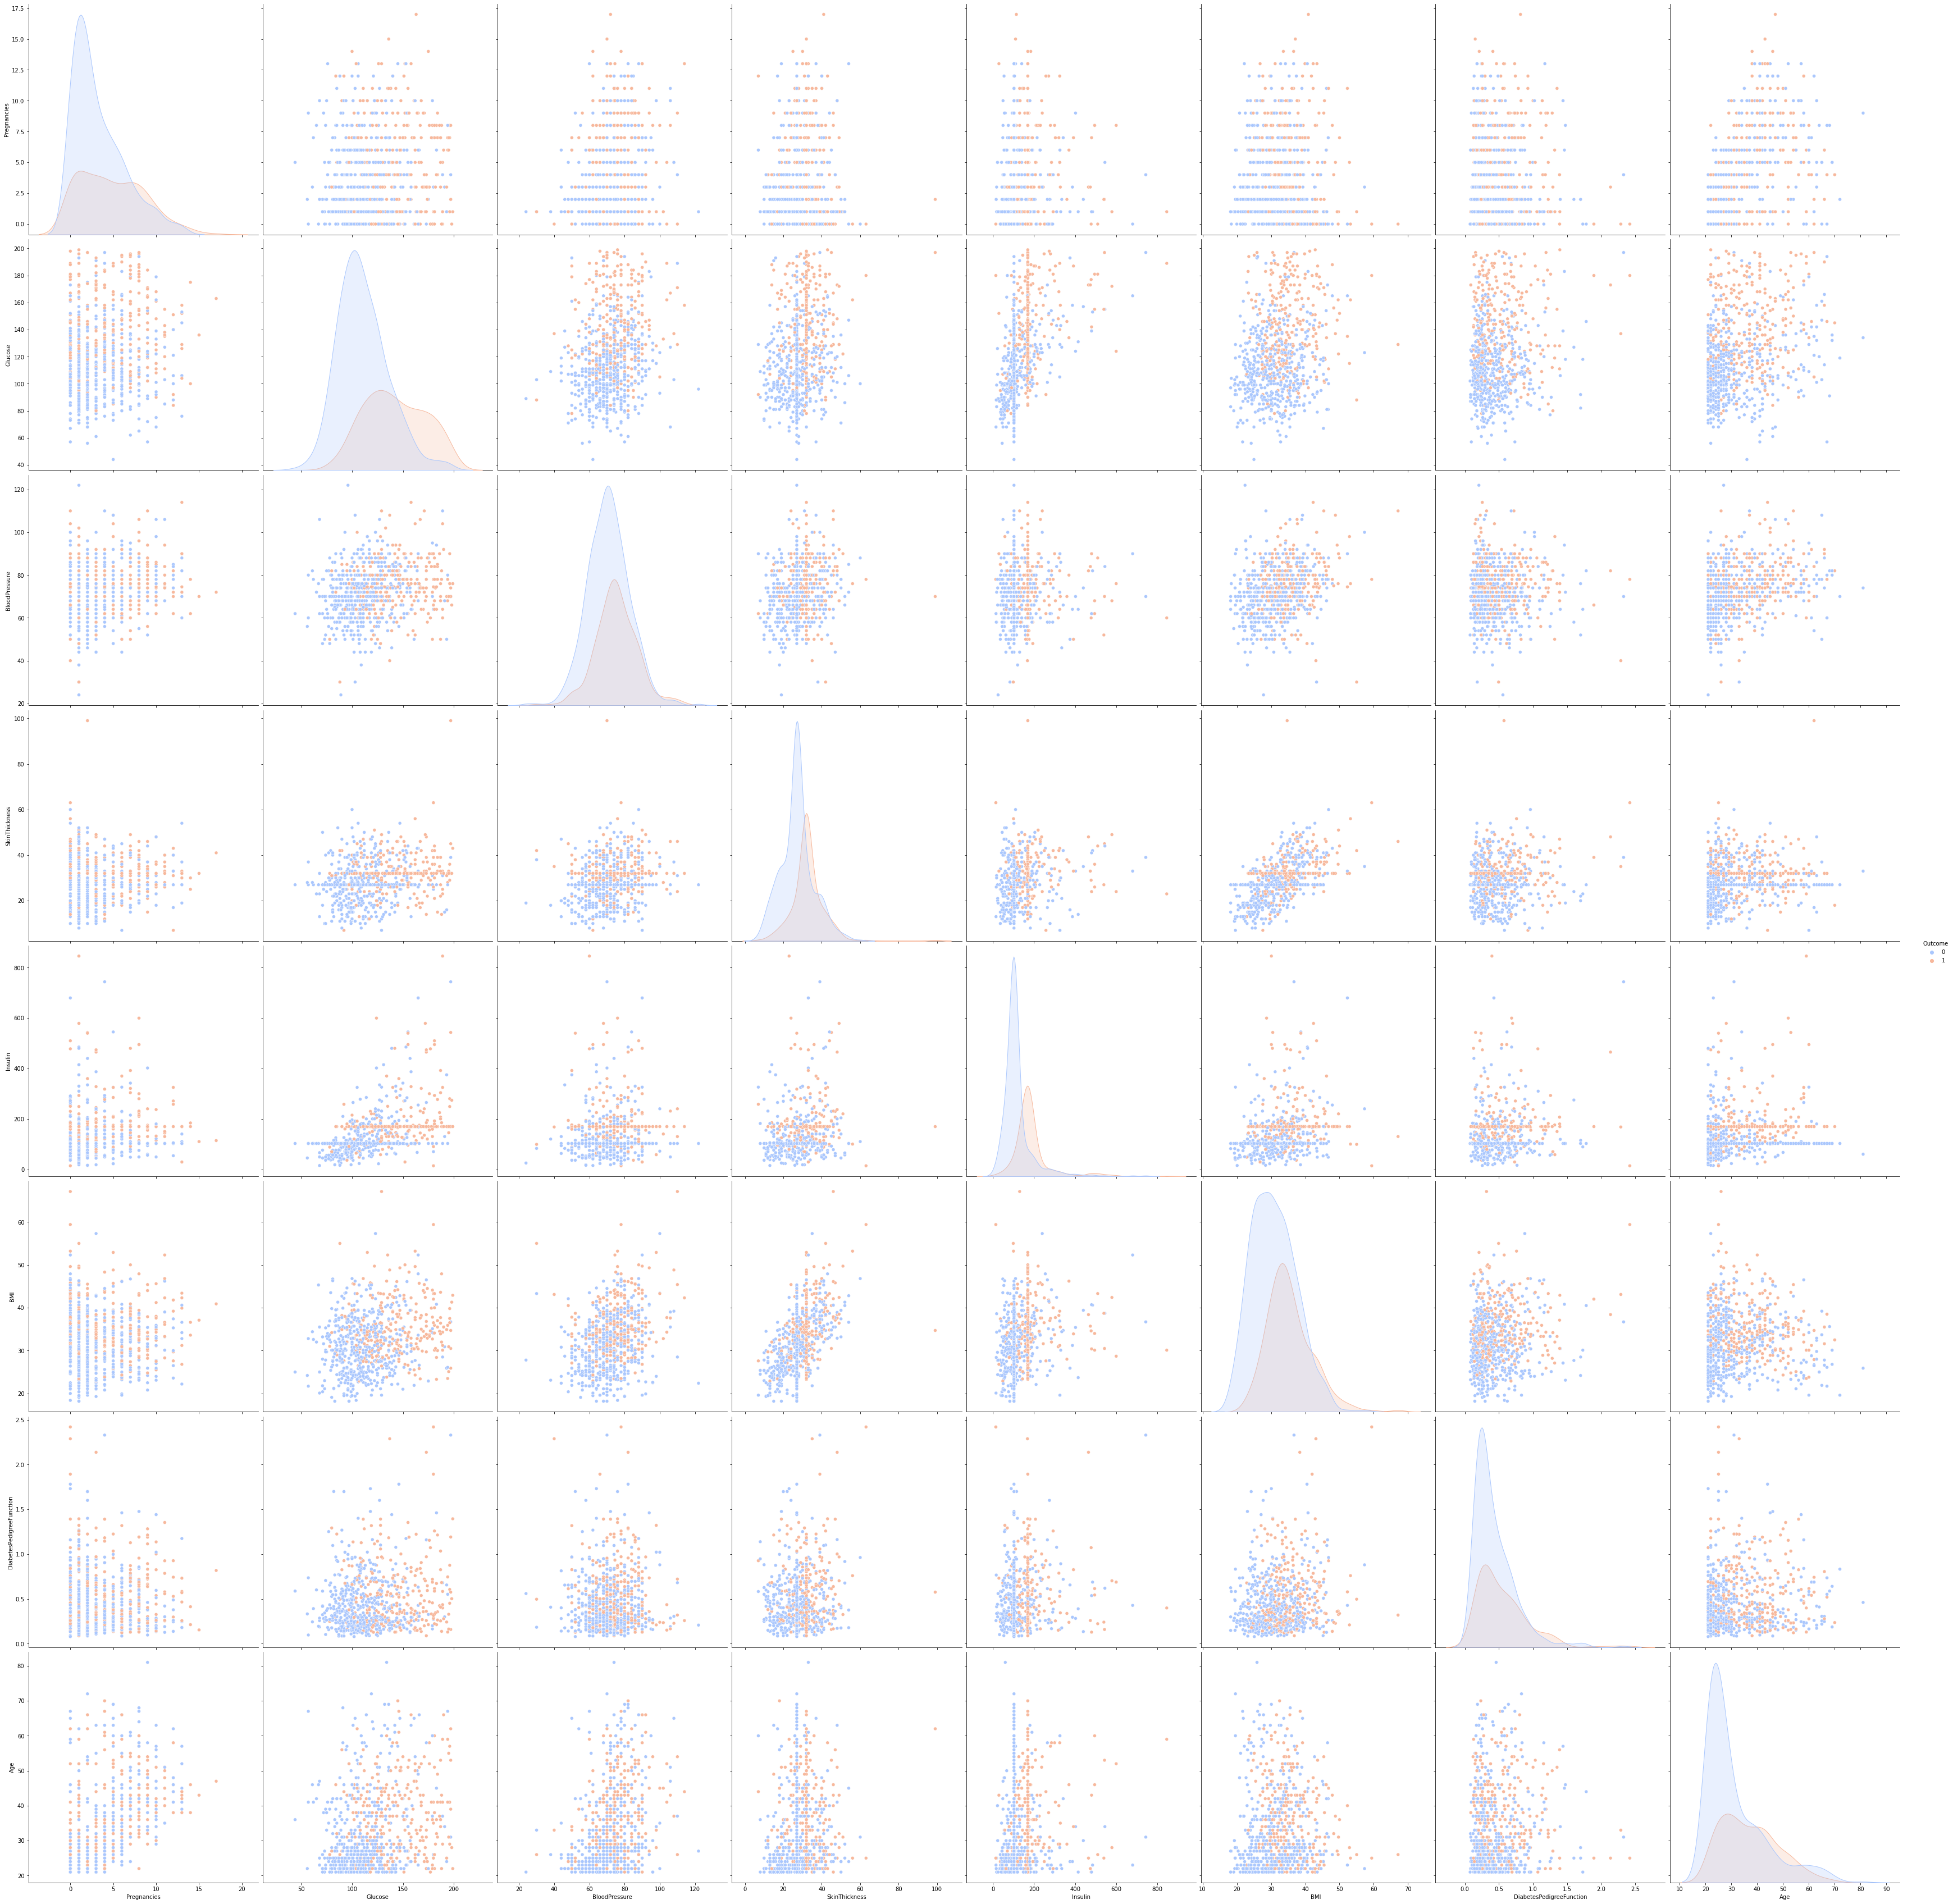

In [75]:
#view the plot of each column with the outcome as their aspects
sns.pairplot(data=df, hue='Outcome',
           palette='coolwarm',height=6,aspect=1)

In [76]:
newdf

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0    169.5  33.6   
1              1     85.0           66.0           29.0    102.5  26.6   
2              8    183.0           64.0           32.0    169.5  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0           76.0           48.0    180.0  32.9   
764            2    122.0           70.0           27.0    102.5  36.8   
765            5    121.0           72.0           23.0    112.0  26.2   
766            1    126.0           60.0           32.0    169.5  30.1   
767            1     93.0           70.0           31.0    102.5  30.4   

     DiabetesPedigreeFunction  Age  
0                       0.627   50  
1                       0.351   31  
2                       0.672   32  
3                       0.167   21  
4                       2.288   33  
..                        ...  ...  
763                     0.171   63  
764                     0.340   27  
765                     0.245   30  
766                     0.349   47  
767                     0.315   23  

[768 rows x 8 columns]

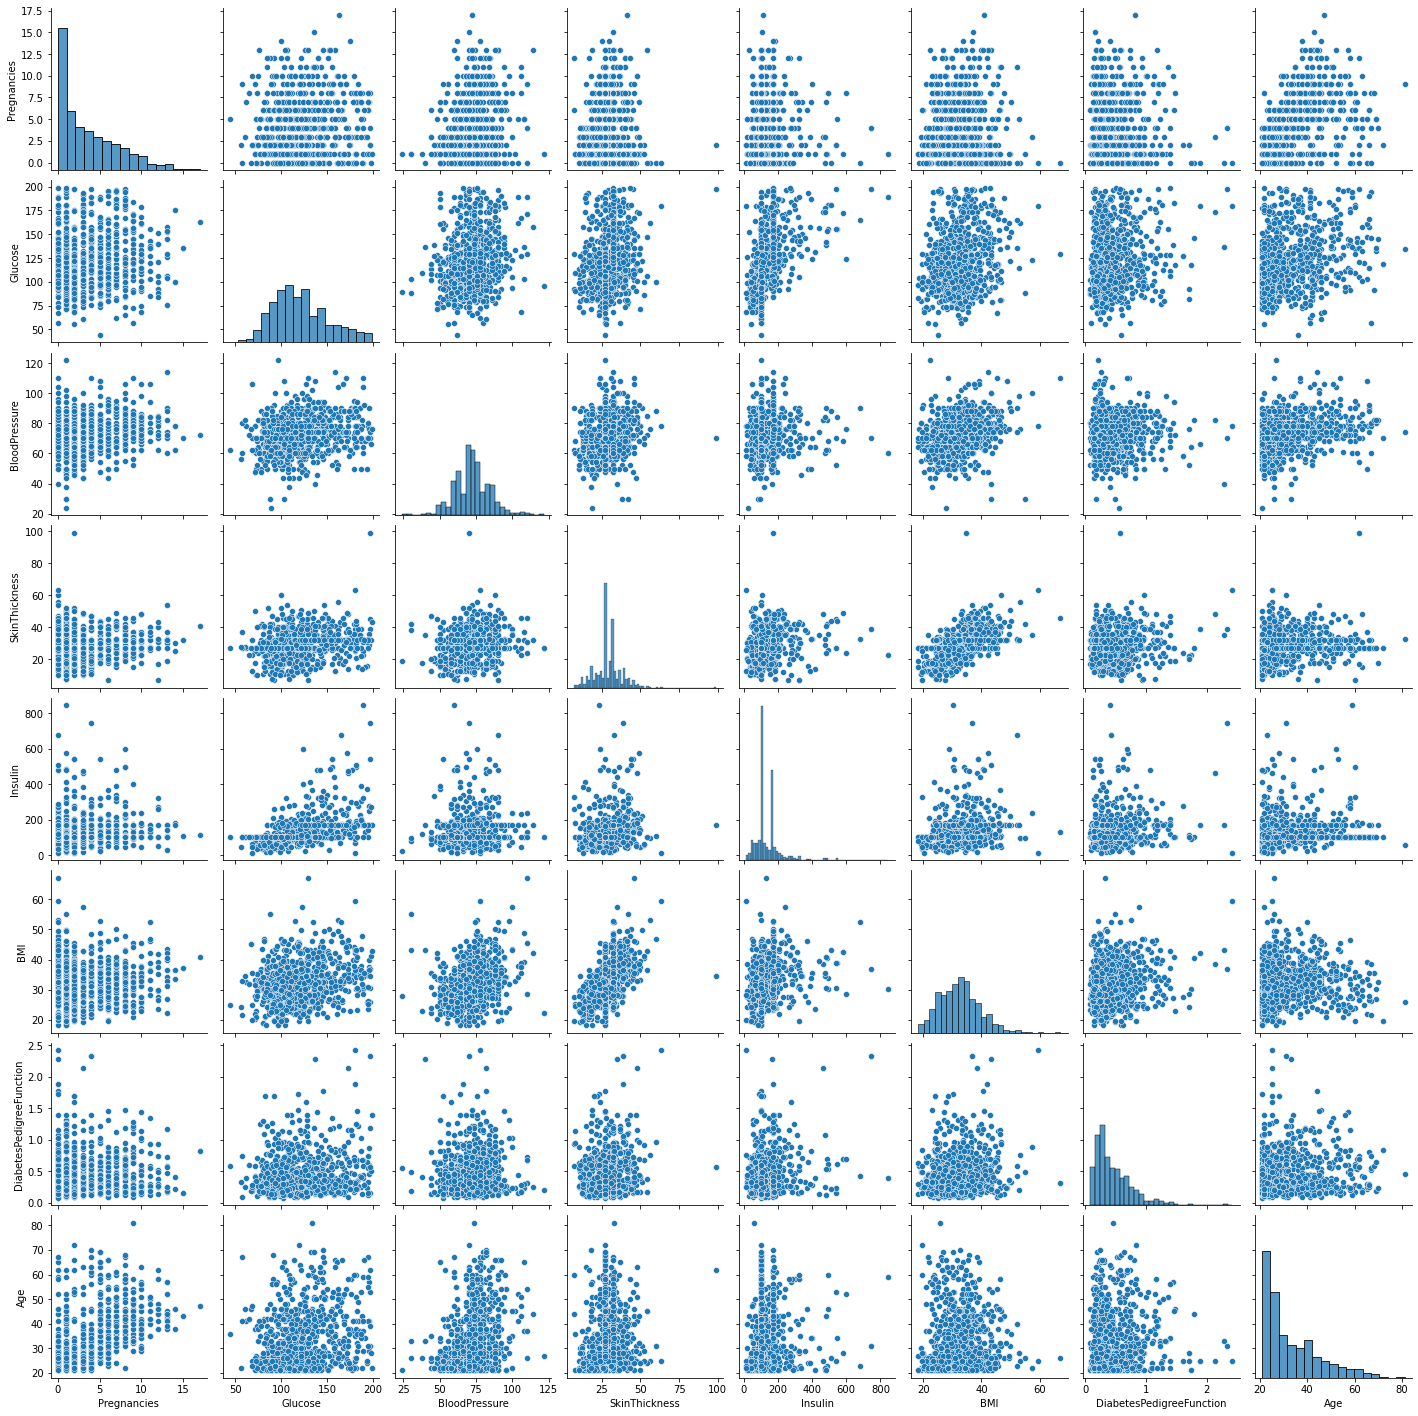

In [77]:
sns.pairplot(newdf,palette='dark')

In [78]:
#normalize data using z-score
sc = StandardScaler()
data_visualization = newdf.copy()
sc.fit(data_visualization)
data_visualization[data_visualization.columns] = sc.transform(data_visualization)

In [84]:
#dimensionality reduction
pca = PCA(n_components=2)
pca.fit(data_visualization)
result = pca.transform(data_visualization)

In [85]:
result[:,0]
result[:,1]

array([-6.13465295e-01,  7.96374721e-02, -5.43459003e-01,  2.67264636e-01,
        3.50673563e+00, -8.42824685e-01,  4.30156198e-01, -1.10081057e+00,
        7.73820845e-01, -1.94726727e+00, -3.23117962e-01, -4.67915658e-01,
       -1.89212467e+00,  1.00869509e+00, -1.41298352e+00, -5.24733232e-01,
        2.15483488e+00, -6.59459150e-01,  1.63505730e+00,  6.41577006e-01,
        1.36828455e+00, -1.77775511e+00, -4.37780672e-01, -9.01211053e-01,
       -2.12281379e+00, -1.80188494e+00, -6.01728783e-01,  8.00791292e-02,
       -3.88137533e+00, -9.17448064e-01, -1.43365746e+00,  1.14761318e+00,
       -5.80802868e-01, -1.58983694e+00, -1.93609575e+00,  3.17383222e-01,
       -1.47176515e+00, -1.05654359e+00,  1.41964932e+00,  6.42810642e-01,
        3.66699899e-01, -4.21373330e-01, -2.74054484e+00, -1.31341434e+00,
       -1.20144906e+00,  3.32034229e+00,  7.54444374e-01,  4.24217110e-01,
        5.29800641e-02, -5.38756056e-01, -6.06829948e-01, -7.39738729e-03,
       -1.12670306e+00, -

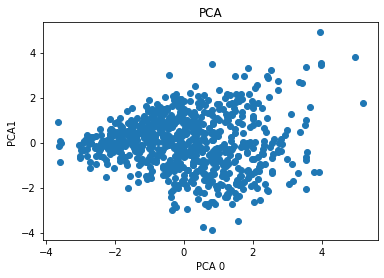

In [86]:
plt.scatter(x=result[:,0], y=result[:,1])
plt.xlabel("PCA 0")
plt.ylabel("PCA1")
plt.title("PCA")
plt.show()

In [88]:
inertia = []

for i in range(2,15):
    kmeans = cluster.KMeans(n_clusters=i,init='k-means++',n_init=15,max_iter=500,random_state=3)
    kmeans.fit(data_visualization)
    inertia.append(kmeans.inertia_)

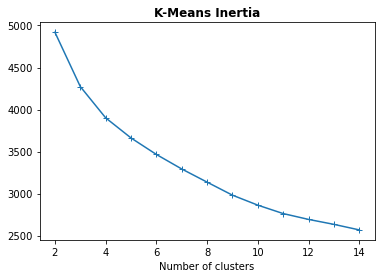

In [89]:
plt.plot(range(2,len(inertia)+2), inertia, marker="+")
plt.xlabel("Number of clusters")
plt.title("K-Means Inertia", fontweight='bold')
plt.show()

In [97]:
#start clustering using k-means
kmeans = cluster.KMeans(n_clusters=2,init='k-means++',random_state = 456)
kmeans_labels = kmeans.fit_predict(data_visualization)
centroids = kmeans.cluster_centers_
pd.Series(kmeans_labels).value_counts()

0    427
1    341
dtype: int64

In [102]:
sc.fit(centroids)
centroid_value = pd.DataFrame(sc.inverse_transform(centroids), columns= newdf.columns)
centroid_value

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.174885 -0.187503      -0.151298      -0.102460 -0.097761 -0.090120   
1     0.347936  0.367665       0.310663       0.231332  0.223493  0.210649   

   DiabetesPedigreeFunction       Age  
0                  0.001010 -0.246970  
1                  0.028073  0.459106

/Users/damdum/anaconda3/envs/dbmProject/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Clustered Data')

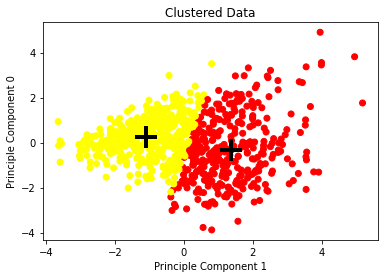

In [98]:
#view clustered data
from matplotlib import colors as mcolors
pcaCentroid = pca.transform(centroids)
cmap = mcolors.LinearSegmentedColormap.from_list("", ["yellow", "red"])

plt.scatter(x=result[:,0], y=result[:,1], c=kmeans_labels, cmap=cmap)
plt.scatter(x=pcaCentroid[:,0], y=pcaCentroid[:,1], marker="+", s = 500, zorder=10, color='black', linewidths=4)
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 0")
plt.title("Clustered Data")

In [100]:
pcaCentroid

array([[-1.09995986,  0.2500869 ],
       [ 1.37736909, -0.31315867]])

In [99]:
    print("Confusion Matrix: \n" ,confusion_matrix(df['Outcome'],kmeans.labels_))
print(classification_report(df['Outcome'],kmeans.labels_))

Confusion Matrix: 
 [[364 136]
 [ 63 205]]
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       500
           1       0.60      0.76      0.67       268

    accuracy                           0.74       768
   macro avg       0.73      0.75      0.73       768
weighted avg       0.76      0.74      0.75       768



accuracy: TP + TN / TP + TN + FP + FN (all correct/all data) = 0,7408854167<br>
missclasification: FP + FN / TP + TN + FP + FN (all incorrect/all data) = 0,2591145833<br>
precision: TP / TP + FP (true positive/predicted positive) = 0,8524590164<br>
recall: TP / TP + FN (true positive/all actual positive) = 0,728<br>
specifity: TN / TN + FP (true negative/ all actual negative) = 0,7649253731

In [101]:
kmeans.labels_

array([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,